## Extracting chords from ChordPro files of The Beatles Songs.

Data was collected from http://getsome.org/guitar/olga/chordpro/b/Beatles/

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
uniqueChordNames = ["A","B", "C", "D", "E", "F", "G"]       


In [3]:
def readChordProFile(chordProFile):
    with open(chordProFile, 'r') as file:
        print(chordProFile)
        content = file.read()
        return content

In [4]:
def cleanChords(chords):
    finalChords = []
    for chord in chords:
        chord = chord.replace("H", "B")
        chord = chord.replace("b", "-")
        chord = chord.replace("min", "m")
        chord = chord.replace("maj", "")
        chord = chord.replace("sus", "")
        chord = chord.replace("dim", "")
        if len(chord) > 3:
            print('Curring long chord ', chord)
            chord = chord[0:3]
        chord = chord.replace("7", "")        
        chord = chord.replace("(", "")
        chord = chord.replace("+", "")
        chord = chord.replace("?", "")
        chord = chord.replace(".", "")
        chord = chord.split("/")[0]
        chord = chord.split("+")[0]
        chord = re.sub(r'\d+', '', chord)
        restWithoutAlphabethic = re.sub(r'[a-zA-Z]+', '', chord[1:])  # use regex to match alphabetic characters
        chord = chord[0] + restWithoutAlphabethic
        
        if chord[0:1] in uniqueChordNames:
            finalChords.append(chord)
    return finalChords

In [5]:
def getChordsOfALine(line, content):
    chord_pattern = r'\[([^\]]+)\]'
    lineChords = []
    if "chorus}" in line.lower():
        lineChords = getChorus(content)
    elif "repeat intro}" in line.lower():
        lineChords = getIntro(content)
    elif "[" in line:
        lineChords = re.findall(chord_pattern, line)   
    return lineChords

In [6]:
def getChorus(content):
    pattern = r"{soc}(.*?){eoc}"
    match = re.search(pattern, content, re.DOTALL)
    chords = []
    if match:
        chorus = match.group(1).strip()
        chord_pattern = r"\[([^\]]*)\]"
        chords = re.findall(chord_pattern, chorus)
        print("Chords in chorus:", chords)
    else:
        print("Chorus section not found.")
    return chords

In [7]:
def getIntro(content):
    chordsOfIntro = []
    inIntro = False
    for line in content.split("\n"): 
        if '{c:intro:}' in line.lower() or '{c:intro}'in line.lower():
            inIntro = True
        elif inIntro:
            lineChords = getChordsOfALine(line, content)
            if len(lineChords) > 0:
                chordsOfIntro.extend(lineChords)
            else:
                inIntro = False
                break
    return chordsOfIntro

In [8]:
class Song:
    def __init__(self, chordProFile):
        self.chordProFile = chordProFile
        self.content = readChordProFile(chordProFile)
        self.chorus = self.getChorus()
        self.chords = self.getChords()
        self.title = self.getTitle()
        self.key = self.getKey()
        
    def getChords(self):
        chords = []
        for line in self.content.split("\n"): 
            lineChords = getChordsOfALine(line, self.content)
            chords.extend(cleanChords(lineChords))
        print('Chord of the song: ' + self.chordProFile, chords)
        return chords
    
    def getChordsBeforeChorus(self):
        chords = []
        for line in self.content.split("\n"): 
            if 'chorus' in line.lower() or '{soc}'in line.lower() or '{start_of_chorus}'in line.lower():
                break
            lineChords = getChordsOfALine(line, self.content)
            chords.extend(cleanChords(lineChords))
        print('Chord of the song: ' + self.chordProFile, chords)
        return chords
        
    def getChorus(self):
        return getChorus(self.content)
    
    def getIntro(self):
        return getIntro(self.content)
    
    def getTitle(self):
        pattern = r"\{title:\s*(.*?)\s*\}"
        match = re.search(pattern, self.content)
        title = ''
        if match:
            title = match.group(1)
            print("The title is:", title)
        else:
            print("Title information not found, using the file name.")
            title = os.path.splitext(os.path.basename(self.chordProFile))[0]
            print("The file name is being used as title:", title)
        return title
    
    def getKey(self):
        pattern = r"{key:\s*([A-G][#b]?)\s*}"
        match = re.search(pattern, self.content)
        key = ''
        if match:
            key = match.group(1)
            print("The key is:", key)
        else:
            print("Key information not found.")
        return key
    

In [9]:
def createChordDictFromChordProFiles(dataFolderPath):
    fileNames = os.listdir(dataFolderPath)
    chordsDict = {}
    longestChordLength = 0
    for file in fileNames:
        print(file)
        if '.DS_Store' in file:
            continue
        chordproFile = dataFolderPath + file
        song = Song(chordproFile)
        chordsDict[song.title] = song.chords
    return chordsDict

In [10]:
pathOfChordTxtFiles = './data/chordpro/'

songDict = createChordDictFromChordProFiles(pathOfChordTxtFiles)
print(songDict)

HelloGoodbye.chopro
./data/chordpro/HelloGoodbye.chopro
Chorus section not found.
Chord of the song: ./data/chordpro/HelloGoodbye.chopro ['C', 'G', 'D', 'E', 'D', 'E', 'D', 'G', 'D', 'C', 'G', 'C', 'E-', 'G', 'C', 'F', 'G', 'C', 'G', 'D', 'E', 'D', 'E', 'D', 'G', 'D', 'C', 'G', 'C', 'E-', 'G', 'C', 'F', 'G', 'C', 'G', 'D', 'E', 'D', 'E', 'D', 'G', 'D', 'C', 'G', 'C', 'E-', 'G', 'C', 'F', 'G', 'C', 'G', 'D', 'E', 'D', 'E', 'D', 'G', 'D', 'C', 'G', 'C', 'E-', 'G', 'C', 'F', 'G', 'C', 'E-', 'G']
The title is: Hello, Goodbye
Key information not found.
TheContinuingStoryOfBungalowBill.chopro
./data/chordpro/TheContinuingStoryOfBungalowBill.chopro
Chorus section not found.
Chorus section not found.
Chorus section not found.
Chorus section not found.
Chord of the song: ./data/chordpro/TheContinuingStoryOfBungalowBill.chopro ['C', 'G', 'C', 'F', 'C', 'F', 'G', 'A', 'E', 'A', 'D', 'A', 'D', 'E', 'A', 'C', 'F', 'G', 'A', 'C', 'F', 'E', 'G', 'A', 'F', 'A', 'C', 'F', 'G', 'A', 'C', 'F', 'G', 'E', 

### Map the string chord names to integer values

In [11]:
distinctChordNames = list(sorted({ele for val in songDict.values() for ele in val}))
print(distinctChordNames)
print(len(distinctChordNames))

['A', 'A-', 'B', 'B-', 'C', 'C#', 'D', 'D#', 'E', 'E-', 'F', 'F#', 'G', 'G#']
14


In [12]:
def mapChordNamesToIndexes(chords):
    indexArr = []
    for i, chord in enumerate(chords):
        indexArr.append(distinctChordNames.index(chord))
    return indexArr

In [13]:
def mapIndexesToChordNames(indexes):
    chords = []
    for i, index in enumerate(indexes):
        chords.append(distinctChordNames[index])
    return chords

In [14]:
finalChordDict = {}
for song in songDict:
        chordArray = songDict[song]
        if len(chordArray) < 10:
            print('Chords are too short, ignoring the song ' + song)
        else:   
            finalChordDict[song] = mapChordNamesToIndexes(chordArray)
        
print(finalChordDict)

Chords are too short, ignoring the song ChristmastimeIsHereAgain
Chords are too short, ignoring the song Anna
Chords are too short, ignoring the song TooMuchMonkeyBusiness
Chords are too short, ignoring the song TwistAndShout
{'Hello, Goodbye': [4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 9, 12], 'The Continuing Story of Bungalow Bill': [4, 12, 4, 10, 4, 10, 12, 0, 8, 0, 6, 0, 6, 8, 0, 4, 10, 12, 0, 4, 10, 8, 12, 0, 10, 0, 4, 10, 12, 0, 4, 10, 12, 8, 12, 0, 10, 0, 4, 10, 12, 0, 4, 10, 12, 8, 12, 0, 10], 'Yellow Submarine': [12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 12, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 12, 6, 12, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 12, 6, 12], 'Strawberry Fields Forever': [12, 6, 9, 

### Create feature arrays

In [15]:
def getFeatureAndTargetArrForEachWindow(chords, windowLength, hopSize, index):
    featureArray = chords[index: index + windowLength]
    targetArray = chords[index + windowLength: index + windowLength + 1]
    return featureArray, targetArray

In [16]:
def getFeaturesAndTargetsByWindowAndHop(chordsDictionary, windowSize, hopSize):
    features = np.empty((0, windowSize), dtype=np.ndarray)
    targets = np.empty((0, 1), dtype=np.ndarray)
    for song in chordsDictionary:
        chordArray = chordsDictionary[song]
        if len(chordArray) < windowSize + 1:
            print('Chords are shorter than number of targets so skipping the song: ' + song)
            continue
        indexProcessed = 0
        while len(chordArray) - indexProcessed > windowSize + 1:
            featureArr, targetArray = getFeatureAndTargetArrForEachWindow(chordArray, windowSize, hopSize, indexProcessed)
            featureArr = np.array(featureArr).reshape(1, len(featureArr))
            features = np.append(features, featureArr, axis=0)
            targetArray = np.array(targetArray).reshape(1, len(targetArray))
            targets = np.append(targets, targetArray, axis=0)
            indexProcessed = indexProcessed + hopSize

    features = np.array(features)
    targets = np.array(targets)
    print(features.shape)
    print(targets.shape)
    print('Slicing the song chords is done!')
    return features, targets

In [17]:
def fillChordArraysUntilDesiredLength(chordArr, desiredLength):
    finalArr = np.zeros(desiredLength, dtype=int)
    chordLength = len(chordArr)
    if chordLength < desiredLength:
        print('Chords are shorter than number of targets so repeating the chords: ' + song)
        quotient, remainder = divmod(desiredLength, chordLength) 
        print(str(chordLength) + " quotient " + str(quotient) + " remainder " + str(remainder))
        for step in range(quotient):
            finalArr[step*chordLength:(step+1)*chordLength] = chordArr
        finalArr[chordLength*quotient: desiredLength] = chordArr[0:remainder]
        print(len(finalArr))
    elif chordLength > desiredLength:
        finalArr = chordArr[0: desiredLength]
    else:
        finalArr = chordArr
    print(len(finalArr))
    print(finalArr)
    return finalArr

In [18]:
def getFeaturesAndTargetsOfFlatSong(chordsDictionary, desiredFeatureLength):
    features = np.zeros((len(chordsDictionary),desiredFeatureLength), dtype=int)
    targets = np.zeros((len(chordsDictionary),1), dtype=int)
    for i, song in enumerate(chordsDictionary):
        chordArray = chordsDictionary[song] 
        finalChords = fillChordArraysUntilDesiredLength(chordArray, desiredFeatureLength+1)
        features[i:] = finalChords[0:desiredFeatureLength]
        targets[i:] = finalChords[desiredFeatureLength:desiredFeatureLength+1]
    print(features.shape)
    print(targets.shape)
    print('Slicing the song chords is done!')
    return features, targets

In [19]:
windowSize = 16
hopSize = 2

featureLength = 50

featureArr, targetArr = getFeaturesAndTargetsByWindowAndHop(finalChordDict, windowSize, hopSize)
#featureArr, targetArr = getFeaturesAndTargetsOfFlatSong(finalChordDict, featureLength)
print(featureArr.shape)
print(targetArr.shape)

print(featureArr)
#print(targetArr)

Chords are shorter than number of targets so skipping the song: ICallYourName
Chords are shorter than number of targets so skipping the song: IveJustSeenAFace
Chords are shorter than number of targets so skipping the song: ThatsAlrightMama
Chords are shorter than number of targets so skipping the song: TicketToRide
(1415, 16)
(1415, 1)
Slicing the song chords is done!
(1415, 16)
(1415, 1)
[[4 12 6 ... 12 4 10]
 [6 8 6 ... 10 12 4]
 [6 8 6 ... 4 12 6]
 ...
 [5 11 5 ... 8 0 0]
 [5 2 8 ... 0 0 10]
 [8 8 0 ... 10 0 12]]


## Train SVMR model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn import svm
import sklearn
import pandas as pd

In [21]:
targets = pd.Series(targetArr.flatten())

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(featureArr, targets, test_size=0.2, random_state=42)
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featureArr, targets, test_size=0.3, random_state=4)


In [23]:
def trainAndGetSVRModel(valueC, valueEpsilon, kernel, featuresTrain, targetTrain):
    startTime = time.time()
    # C tolerans, epsilon the distance from the line
    # The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified margin, called the maximum error, ϵ (epsilon).
    # additional hyperparameter, C, that we can tune. As C increases, our tolerance for points outside of ϵ also increases. As C approaches 0, the tolerance approaches 0 and the equation collapses into the simplified (although sometimes infeasible) one.
    regr = svm.SVR(C=valueC, epsilon=valueEpsilon, kernel=kernel)
    regr.fit(featuresTrain, targetTrain)
    endTime = time.time()
    timeSpent = endTime - startTime
    print(f"Time spent for the training is: {timeSpent:.4f} seconds, for values: " + str(valueC) + " epsilon: " + str(valueEpsilon) + " kernel " + kernel)
    return regr

In [24]:
targetPredicted1 = trainAndGetSVRModel(0.05, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted2 = trainAndGetSVRModel(0.10, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted3 = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted4 = trainAndGetSVRModel(10.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted5 = trainAndGetSVRModel(50.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)

Time spent for the training is: 0.0527 seconds, for values: 0.05 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0411 seconds, for values: 0.1 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0466 seconds, for values: 1.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0737 seconds, for values: 10.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.1518 seconds, for values: 50.0 epsilon: 0.001 kernel rbf


In [25]:
def getErrorValues(targetTest, targetPredicted, paramName, paramValue):
    return { paramName: paramValue,
            'Mean Squared Err': '%.4f'% sklearn.metrics.mean_squared_error(targetTest, targetPredicted),
            'Mean Abs Err':  '%.4f'% sklearn.metrics.mean_absolute_error(targetTest, targetPredicted),
            'Max Err':  '%.4f'% sklearn.metrics.max_error(targetTest, targetPredicted),
            'Median Abs Err':  '%.4f'% sklearn.metrics.median_absolute_error(targetTest, targetPredicted),
            'R2 score':  '%.4f'% sklearn.metrics.r2_score(targetTest, targetPredicted),
            'Variance score':  '%.4f'% sklearn.metrics.explained_variance_score(targetTest, targetPredicted)}

In [26]:
def highlight(value):
        return 'border: 1px solid black; padding: 5px'
    
def getDfWithStyle(df):
    return df.style.applymap(highlight)

In [27]:
dataC = getErrorValues(targetTest, targetPredicted1, 'C Value', '0.05')
resultCDf = pd.DataFrame(dataC, index=[0])
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted2, "C Value", '0.10')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted3, "C Value", '1.00')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted4, "C Value", '10.00')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted5, "C Value", '50.00')

display(getDfWithStyle(resultCDf))

,C Value,Mean Squared Err,Mean Abs Err,Max Err,Median Abs Err,R2 score,Variance score
0,0.05,15.8847,3.2842,7.3181,2.4313,0.0179,0.0223
1,0.10,15.5802,3.2673,7.6355,2.5732,0.0367,0.0407
2,1.00,15.0958,3.1565,9.9557,2.9104,0.0666,0.0666
3,10.00,15.4906,3.0206,11.9218,2.4729,0.0422,0.0436
4,50.00,18.1074,3.0895,13.8186,2.4538,-0.1196,-0.1192


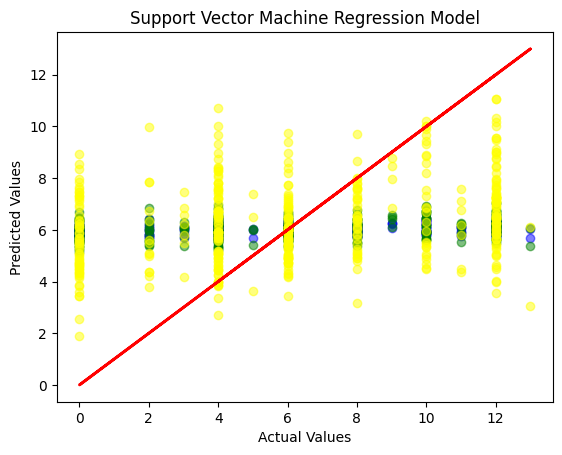

In [28]:
plt.scatter(targetTest, targetPredicted1, color='blue', label='C 0.01', alpha=0.5)
plt.scatter(targetTest, targetPredicted2, color='green', label='C 0.05', alpha=0.5)
plt.scatter(targetTest, targetPredicted3, color='yellow', label='C 0.10', alpha=0.5)
plt.plot(targetTest, targetTest, color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Support Vector Machine Regression Model')
plt.show()

In [29]:
targetPredictedByRbf = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByLinear = trainAndGetSVRModel(1.0, 0.001, 'linear', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByPoly = trainAndGetSVRModel(1.0, 0.001, 'poly', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedBySigmoid = trainAndGetSVRModel(1.0, 0.001, 'sigmoid', featuresTrain, targetTrain).predict(featuresTest)


Time spent for the training is: 0.0475 seconds, for values: 1.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.2926 seconds, for values: 1.0 epsilon: 0.001 kernel linear
Time spent for the training is: 0.1143 seconds, for values: 1.0 epsilon: 0.001 kernel poly
Time spent for the training is: 0.0532 seconds, for values: 1.0 epsilon: 0.001 kernel sigmoid


In [30]:
dataKernel = getErrorValues(targetTest, targetPredictedByRbf, 'Kernel Value', 'rbf')
resultKernelDf = pd.DataFrame(dataKernel, index=[0])
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedByLinear, 'Kernel Value','linear')
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedByPoly, 'Kernel Value', 'poly')
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedBySigmoid, 'Kernel Value', 'sigmoid')

display(getDfWithStyle(resultKernelDf))


,Kernel Value,Mean Squared Err,Mean Abs Err,Max Err,Median Abs Err,R2 score,Variance score
0,rbf,15.0958,3.1565,9.9557,2.9104,0.0666,0.0666
1,linear,15.7500,3.2513,9.8273,3.1365,0.0262,0.0263
2,poly,17.0215,3.2188,12.2488,2.7484,-0.0524,-0.0491
3,sigmoid,146.0625,8.9192,50.7376,6.7868,-8.0310,-7.8315


In [31]:
targetPredictedByEps1 = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps2 = trainAndGetSVRModel(1.0, 0.005, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps3 = trainAndGetSVRModel(1.0, 0.010, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps4 = trainAndGetSVRModel(1.0, 0.050, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps5 = trainAndGetSVRModel(1.0, 0.100, 'rbf', featuresTrain, targetTrain).predict(featuresTest)


Time spent for the training is: 0.0550 seconds, for values: 1.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0421 seconds, for values: 1.0 epsilon: 0.005 kernel rbf
Time spent for the training is: 0.0415 seconds, for values: 1.0 epsilon: 0.01 kernel rbf
Time spent for the training is: 0.0443 seconds, for values: 1.0 epsilon: 0.05 kernel rbf
Time spent for the training is: 0.0403 seconds, for values: 1.0 epsilon: 0.1 kernel rbf


In [32]:
dataEpsion = getErrorValues(targetTest, targetPredictedByEps1, "Epsilon Value", '0.001')
resultEpsilonDf = pd.DataFrame(dataEpsion, index=[0])
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps2, "Epsilon Value", '0.005')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps3, "Epsilon Value", '0.010')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps4, "Epsilon Value", '0.050')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps5, "Epsilon Value", '0.100')

display(getDfWithStyle(resultEpsilonDf))


,Epsilon Value,Mean Squared Err,Mean Abs Err,Max Err,Median Abs Err,R2 score,Variance score
0,0.001,15.0958,3.1565,9.9557,2.9104,0.0666,0.0666
1,0.005,15.0936,3.1565,9.9568,2.9098,0.0668,0.0668
2,0.010,15.0908,3.1565,9.9580,2.9088,0.0669,0.0669
3,0.050,15.0648,3.1553,9.9566,2.9016,0.0685,0.0685
4,0.100,15.0354,3.1536,9.9593,2.9075,0.0704,0.0704


### Train and Predict next n chords for given song

In [33]:
def prepareSongForPrediction(beginningChords, fullChords, featureSize):
    finalArr = np.zeros((1, featureSize), dtype=int)
    lengthOfBeginning = len(beginningChords)
    lengthOfFullSong = len(fullChords)
    if lengthOfBeginning < featureSize:
        chordArray = np.zeros(featureSize, dtype=int)
        print('Beginning chords are shorter than number of features, repeating the chords')
        chordArray[featureSize-lengthOfBeginning:lengthOfBeginning] = beginningChords
        quotient, remainder = divmod(featureSize-lengthOfBeginning, lengthOfFullSong) 
        chordArray[0,quotient] = chordArr[lengthOfFullSong-quotient:lengthOfFullSong]
        for step in range(quotient):
            start = quotient + step*chordLength
            end = quotient + (step+1)*chordLength
            chordArray[start:end] = chordArr
        finalArr[0:featureSize] = chordArray
    elif lengthOfBeginning > featureSize:
        finalArr[0:featureSize] = beginningChords[lengthOfBeginning-featureSize: lengthOfBeginning]
    else:
        finalArr[0:featureSize] = beginningChords
    print(finalArr)
    final2dArr = np.zeros((1,featureSize), dtype=int)
    final2dArr[1:] = finalArr
    print(final2dArr)
    return finalArr

In [34]:
regression = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain)

Time spent for the training is: 0.0536 seconds, for values: 1.0 epsilon: 0.001 kernel rbf


In [35]:
songFileName = 'AllYouNeedIsLove.chopro'
songToGenerate = Song(pathOfChordTxtFiles + songFileName)
fullChords = songToGenerate.getChords()
chordsBeforeChorus = songToGenerate.getChordsBeforeChorus()
chorus = songToGenerate.getChorus()

chordsBeforeChorusInt = mapChordNamesToIndexes(chordsBeforeChorus)
fullChordsInt = mapChordNamesToIndexes(fullChords)

featureOfSong = prepareSongForPrediction(chordsBeforeChorusInt, fullChordsInt, windowSize)
print(featureOfSong.shape)

./data/chordpro/AllYouNeedIsLove.chopro
Chords in chorus: ['G', 'Am7', 'D7', 'G', 'Am7', 'D7', 'G', 'B7', 'Em', 'G', 'C', 'D7', 'C']
Chords in chorus: ['G', 'Am7', 'D7', 'G', 'Am7', 'D7', 'G', 'B7', 'Em', 'G', 'C', 'D7', 'C']
Chords in chorus: ['G', 'Am7', 'D7', 'G', 'Am7', 'D7', 'G', 'B7', 'Em', 'G', 'C', 'D7', 'C']
Chord of the song: ./data/chordpro/AllYouNeedIsLove.chopro ['G', 'D', 'E', 'G', 'D', 'E', 'D', 'G', 'D', 'G', 'D', 'E', 'G', 'D', 'E', 'D', 'G', 'D', 'G', 'A', 'D', 'G', 'A', 'D', 'G', 'B', 'E', 'G', 'C', 'D', 'C', 'G', 'D', 'E', 'G', 'D', 'E', 'D', 'G', 'D', 'G', 'A', 'D', 'G', 'A', 'D', 'G', 'B', 'E', 'G', 'C', 'D', 'C', 'G', 'A', 'D', 'G', 'A', 'D', 'G', 'B', 'E', 'G', 'C', 'D', 'C']
The title is: All You Need Is Love
Key information not found.
Chords in chorus: ['G', 'Am7', 'D7', 'G', 'Am7', 'D7', 'G', 'B7', 'Em', 'G', 'C', 'D7', 'C']
Chords in chorus: ['G', 'Am7', 'D7', 'G', 'Am7', 'D7', 'G', 'B7', 'Em', 'G', 'C', 'D7', 'C']
Chord of the song: ./data/chordpro/AllYouNe

In [36]:
def generatePredictedChords(regr, beginningChords, chordsLengthToPredict):
    print(beginningChords)
    featureArrLength = len(beginningChords[0:])
    predictedChords = np.zeros(chordsLengthToPredict, dtype=int)
    for i in range(chordsLengthToPredict):
        nextValue = int(regr.predict(beginningChords))
        predictedChords[i] = nextValue
        #print("predicted value ", str(nextValue))
        beginningChords = np.roll(beginningChords, -1, axis=1)
        beginningChords[:, -1] = nextValue
        print(beginningChords)
    print('Done, chords predicted: ')
    print(predictedChords)
    return predictedChords

In [37]:
chorusLengthToPredict = len(chorus)

composedChords = generatePredictedChords(regression, featureOfSong, chorusLengthToPredict)
chordNamesOfComposition = mapIndexesToChordNames(composedChords)
print(chordNamesOfComposition)

[[ 8 12  6  8  6 12  6 12  6  8 12  6  8  6 12  6]]
[[12  6  8  6 12  6 12  6  8 12  6  8  6 12  6  8]]
[[ 6  8  6 12  6 12  6  8 12  6  8  6 12  6  8  7]]
[[ 8  6 12  6 12  6  8 12  6  8  6 12  6  8  7  9]]
[[ 6 12  6 12  6  8 12  6  8  6 12  6  8  7  9  7]]
[[12  6 12  6  8 12  6  8  6 12  6  8  7  9  7  9]]
[[ 6 12  6  8 12  6  8  6 12  6  8  7  9  7  9  6]]
[[12  6  8 12  6  8  6 12  6  8  7  9  7  9  6 11]]
[[ 6  8 12  6  8  6 12  6  8  7  9  7  9  6 11  5]]
[[ 8 12  6  8  6 12  6  8  7  9  7  9  6 11  5  9]]
[[12  6  8  6 12  6  8  7  9  7  9  6 11  5  9  6]]
[[ 6  8  6 12  6  8  7  9  7  9  6 11  5  9  6  9]]
[[ 8  6 12  6  8  7  9  7  9  6 11  5  9  6  9  6]]
[[ 6 12  6  8  7  9  7  9  6 11  5  9  6  9  6  8]]
Done, chords predicted: 
[ 8  7  9  7  9  6 11  5  9  6  9  6  8]
['E', 'D#', 'E-', 'D#', 'E-', 'D', 'F#', 'C#', 'E-', 'D', 'E-', 'D', 'E']


Lets convert the composition to a listenable format

In [38]:
from pychord import Chord
import pretty_midi


def createMidi(chords):
    midi_data = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    length = 1
    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=4):
            note_number = pretty_midi.note_name_to_number(note_name)
            note = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)
            piano.notes.append(note)
    midi_data.instruments.append(piano)
    midi_data.write('composedMidi.mid')


#chords_str = ["C", "Dm7", "G", "C"]
chords = [Chord(c) for c in chordNamesOfComposition]
createMidi(chords)

### Create an Http Get Api

In [39]:
#raise ValueError("Donw allow api to be run"):

In [40]:
from flask import Flask, jsonify, request

chordNamesOfComposition = []

app = Flask(__name__)

@app.route('/trainAndGenerate', methods=['POST'])
def trainSVRAndGenerateComposition():
    print('Api Called')
    startTime = time.time()
    inputArray = []
    numberOfResultsToPredict = 0
    try:
        data = request.json
        inputArrayOfChords = data['chordArayToTrain']
        numberOfResultsToPredict = data['numberOfResultsToPredict']
        inputArrayOfChords = mapChordNamesToIndexes(inputArrayOfChords)
    except:
        print("An exception occurred")
        raise ValueError("Chords should be provided in a string array of chordArayToTrain")
    
    print(inputArrayOfChords)
    print(numberOfResultsToPredict)
    windowSize = 16
    hopSize = 2
    dictOfSong = {"songName": inputArrayOfChords}
    featureArr, targetArr = getFeaturesAndTargetsByWindowAndHop(dictOfSong, windowSize, hopSize)
    targets = pd.Series(targetArr.flatten())
    featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featureArr, targets, test_size=0.3, random_state=4)
    regression = trainAndGetSVRModel(1.00, 0.001, 'rbf', featuresTrain, targetTrain)
    
    arrayForPrediction = prepareSongForPrediction(inputArrayOfChords, inputArrayOfChords, windowSize)
    composedChords = generatePredictedChords(regression, arrayForPrediction, numberOfResultsToPredict)
    chordNamesOfComposition = mapIndexesToChordNames(composedChords)
    print(chordNamesOfComposition)
    endTime = time.time()
    timeSpent = endTime - startTime
    print(f"Time spent for the  training and prediction is: {timeSpent:.4f} seconds")
    return jsonify({'composedArray': chordNamesOfComposition})



if __name__ == '__main__':
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/May/2023 13:38:09] "POST /trainAndGenerate HTTP/1.1" 200 -


Api Called
[12, 6, 8, 12, 6, 8, 6, 12, 6, 12, 6, 8, 12, 6, 8, 6, 12, 6, 12, 0, 6, 12, 0, 6, 12, 2, 8, 12, 4, 6, 4, 12, 6, 8, 12, 6, 8, 6, 12, 6, 12, 0, 6, 12, 0, 6, 12, 2, 8, 12, 4, 6, 4, 12, 0, 6, 12, 0, 6, 12, 2, 8, 12, 4, 6, 4]
8
(25, 16)
(25, 1)
Slicing the song chords is done!
Time spent for the training is: 0.0046 seconds, for values: 1.0 epsilon: 0.001 kernel rbf
[[ 4  6  4 12  0  6 12  0  6 12  2  8 12  4  6  4]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[ 4  6  4 12  0  6 12  0  6 12  2  8 12  4  6  4]]
[[ 6  4 12  0  6 12  0  6 12  2  8 12  4  6  4  6]]
[[ 4 12  0  6 12  0  6 12  2  8 12  4  6  4  6  6]]
[[12  0  6 12  0  6 12  2  8 12  4  6  4  6  6  6]]
[[ 0  6 12  0  6 12  2  8 12  4  6  4  6  6  6  8]]
[[ 6 12  0  6 12  2  8 12  4  6  4  6  6  6  8  6]]
[[12  0  6 12  2  8 12  4  6  4  6  6  6  8  6  6]]
[[ 0  6 12  2  8 12  4  6  4  6  6  6  8  6  6  7]]
[[ 6 12  2  8 12  4  6  4  6  6  6  8  6  6  7  6]]
Done, chords predicted: 
[6 6 6 8 6 6 7 6]
['D', 'D', 'D', 'E', 'D', 'D